In [1]:
# Imports
library(Seurat)
library(SingleCellExperiment)
library(SingleR)
library(celldex)    
library(ggplot2)
library(clustree)
library(gridExtra)

Warning message:
"package 'Seurat' was built under R version 4.4.2"
Loading required package: SeuratObject

Warning message:
"package 'SeuratObject' was built under R version 4.4.2"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.4.2"

Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
"package 'matrixStats' was built under R version 4.4.2"

Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, 

In [2]:
# Set wd
setwd("../../../Data/Horstmann et al. (2024)")
list.files()
getwd()

# Change setting for visualizing plots within VSCODE
options(repr.plot.width=15, repr.plot.height=12)

# Read in data
P1 <- Read10X(data.dir = "P1")
P2 <- Read10X(data.dir = "P2")
P3 <- Read10X(data.dir = "P3")
P4 <- Read10X(data.dir = "P4")
P5 <- Read10X(data.dir = "P5")
P6 <- Read10X(data.dir = "P6")
P7 <- Read10X(data.dir = "P7")
P8 <- Read10X(data.dir = "P8")

# Create Seurat objects
P1 <- CreateSeuratObject(P1, project="Horstmann et al. (2023), P1")
P2 <- CreateSeuratObject(P2, project="Horstmann et al. (2023), P2")
P3 <- CreateSeuratObject(P3, project="Horstmann et al. (2023), P3")
P4 <- CreateSeuratObject(P4, project="Horstmann et al. (2023), P4")
P5 <- CreateSeuratObject(P5, project="Horstmann et al. (2023), P5")
P6 <- CreateSeuratObject(P6, project="Horstmann et al. (2023), P6")
P7 <- CreateSeuratObject(P7, project="Horstmann et al. (2023), P7")
P8 <- CreateSeuratObject(P8, project="Horstmann et al. (2023), P8")

# Merge the Seurat objects
samples <- merge(P1, y=list(P2, P3, P4, P5, P6, P7, P8))

# Merge layers
samples[["RNA"]] <- JoinLayers(samples[["RNA"]])

# Export R object for all mice integration
samples[["Species"]] <- "Human"
saveRDS(samples, file = "Horstmann_raw.rds")


[1] "Horstmann_macrophages_annotated.rds" 
 [2] "Horstmann_macrophages_annotated2.rds"
 [3] "integrated_horstmann.rds"            
 [4] "P1"                                  
 [5] "P2"                                  
 [6] "P3"                                  
 [7] "P4"                                  
 [8] "P5"                                  
 [9] "P6"                                  
[10] "P7"                                  
[11] "P8"

[1] "c:/Users/phili/Desktop/BMW Jaar 3/Afstudeerscriptie/project_scriptie/Data/Horstmann et al. (2024)"

Warning message:
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."


In [3]:
# Preprocessing function which performs a basic workflow for scRNA seq analysis
pre_process <- function(data, nFeatures_RNA = 200, nCounts_RNA = 3, percents.mt = 5, pattern = "MT", resolutions = seq(0.5, 1.5, by = 0.1), k.weights = 100) {
    # Split
    data[["RNA"]] <- split(data[["RNA"]], f = data$orig.ident)

    # Get percentage mt                      
    data[["percent.mt"]] <- PercentageFeatureSet(data, pattern = sprintf("^%s-", pattern))

    # Subsets
    data <- subset(x = data, subset = nFeature_RNA >= nFeatures_RNA & nCount_RNA >= nCounts_RNA & percent.mt <= percents.mt)

    # Normalization
    data <- NormalizeData(data, normalization.method = "LogNormalize", scale.factor = 10000)
    
    # Find Variable features
    data <- FindVariableFeatures(data, selection.method = "vst", nfeatures = 2000)
    
    # Scale Data
    data <- ScaleData(data, vars.to.regress = c("percent.mt", "nFeature_RNA"))
    
    # Run PCA
    data <- RunPCA(data, npcs = 100, verbose=FALSE)

    # Get significant PCAs through Jackstrawplot
    data <- JackStraw(data, num.replicate = 100)
    data <- ScoreJackStraw(data, dims = 1:20)

    # Check the amount of significant pcs
    significant_pcs <- length(which(data@reductions$pca@jackstraw$overall.p.values < 0.05))

    # Run UMAP
    data <- RunUMAP(data, reduction = "pca", dims = 1:significant_pcs, verbose=FALSE)

    # Integrate # Replaced CCA by Harmony
    data <- IntegrateLayers(object = data, method = CCAIntegration, orig.reduction = "pca", new.reduction = "integrated.cca", k.weight = k.weights)

    data[["RNA"]] <- JoinLayers(data[["RNA"]])

    # Post integration processing
    data <- RunPCA(data, npcs = 100, verbose=FALSE)

    # Get significant PCAs through Jackstrawplot
    data <- JackStraw(data, num.replicate = 100)
    data <- ScoreJackStraw(data, dims = 1:20)

    # Check the amount of significant pcs
    significant_pcs <- length(which(data@reductions$pca@jackstraw$overall.p.values < 0.05))

    # Clustering
    data <- FindNeighbors(data, reduction = "integrated.cca", dims = 1:significant_pcs)
    data <- FindClusters(data, resolution = resolutions)
    data <- RunUMAP(data, dims = 1:significant_pcs, reduction = "integrated.cca", verbose=FALSE)

    return(data)
}

data <- pre_process(samples, pattern= "MT", percents.mt = 10)

Normalizing layer: counts.P1

Normalizing layer: counts.P2

Normalizing layer: counts.P3

Normalizing layer: counts.P4

Normalizing layer: counts.P5

Normalizing layer: counts.P6

Normalizing layer: counts.P7

Normalizing layer: counts.P8

Finding variable features for layer counts.P1

Finding variable features for layer counts.P2

Finding variable features for layer counts.P3

Finding variable features for layer counts.P4

Finding variable features for layer counts.P5

Finding variable features for layer counts.P6

Finding variable features for layer counts.P7

Finding variable features for layer counts.P8

Regressing out percent.mt, nFeature_RNA

Centering and scaling data matrix

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
Finding all pairwise a

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 35112
Number of edges: 1370691

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9124
Number of communities: 20
Elapsed time: 10 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 35112
Number of edges: 1370691

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9046
Number of communities: 21
Elapsed time: 10 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 35112
Number of edges: 1370691

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8970
Number of communities: 24
Elapsed time: 12 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 35112
Number of edges: 1370691

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8901
Number of communities: 24
Elapsed time: 11 seconds
Modu

In [4]:
# Save
saveRDS(data, file = "integrated_horstmann.rds")

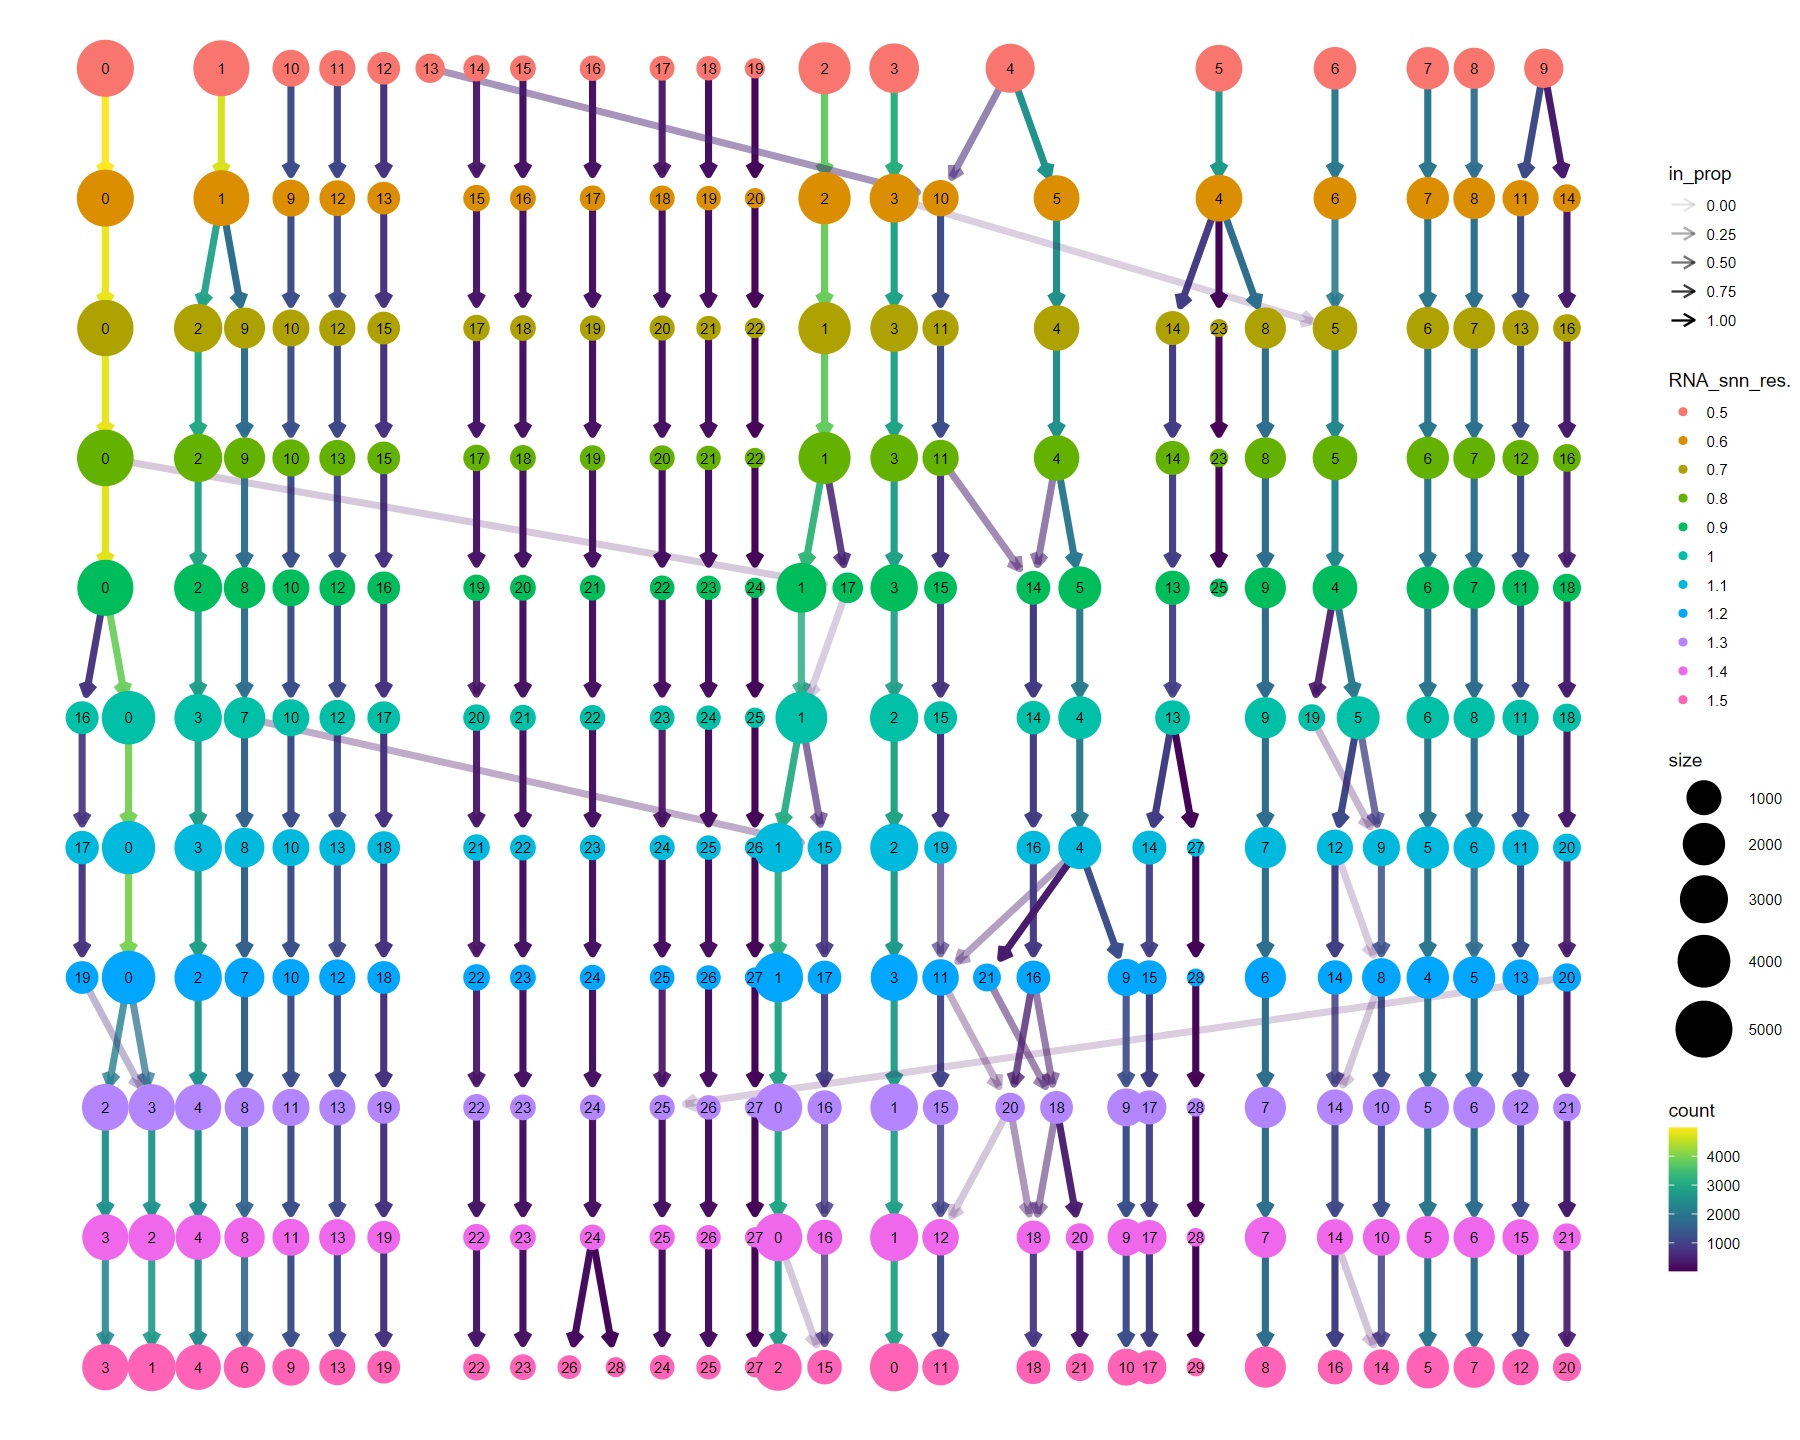

In [7]:
# This cell is meant to analyze the different resolutions and see which one is the best
# Change setting for visualizing plots within VSCODE
options(repr.plot.width=15, repr.plot.height=12)
clustree(data, prefix= "RNA_snn_res.", layout = "sugiyama")

In [ ]:
# Assign the slot "Seurat Cluster" to the desired resolution
data$seurat_clusters <- data$`RNA_snn_res.1`

,0,1,2,3,4,5,6,7,8,9,⋯,16,17,18,19,20,21,22,23,24,25
B_cell,0,0,0,0,0,0,0,0,0,0,⋯,0,0,80,0,0,0,1,119,1,1
Chondrocytes,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,9,0,0,0
CMP,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,50
DC,0,0,0,0,1,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,22,0
Endothelial_cells,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,132,0,0,0
Erythroblast,0,0,0,0,0,0,0,0,0,0,⋯,0,2,0,0,2,0,0,0,0,0
GMP,0,0,0,0,0,0,0,0,0,0,⋯,0,4,0,0,0,0,0,0,3,0
HSC_CD34+,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,3
Macrophage,0,0,0,0,4,0,0,0,0,0,⋯,0,4,0,0,0,0,0,2,1,1
Monocyte,0,0,1,0,1945,5,0,0,0,0,⋯,0,13,0,0,1,253,7,2,142,1


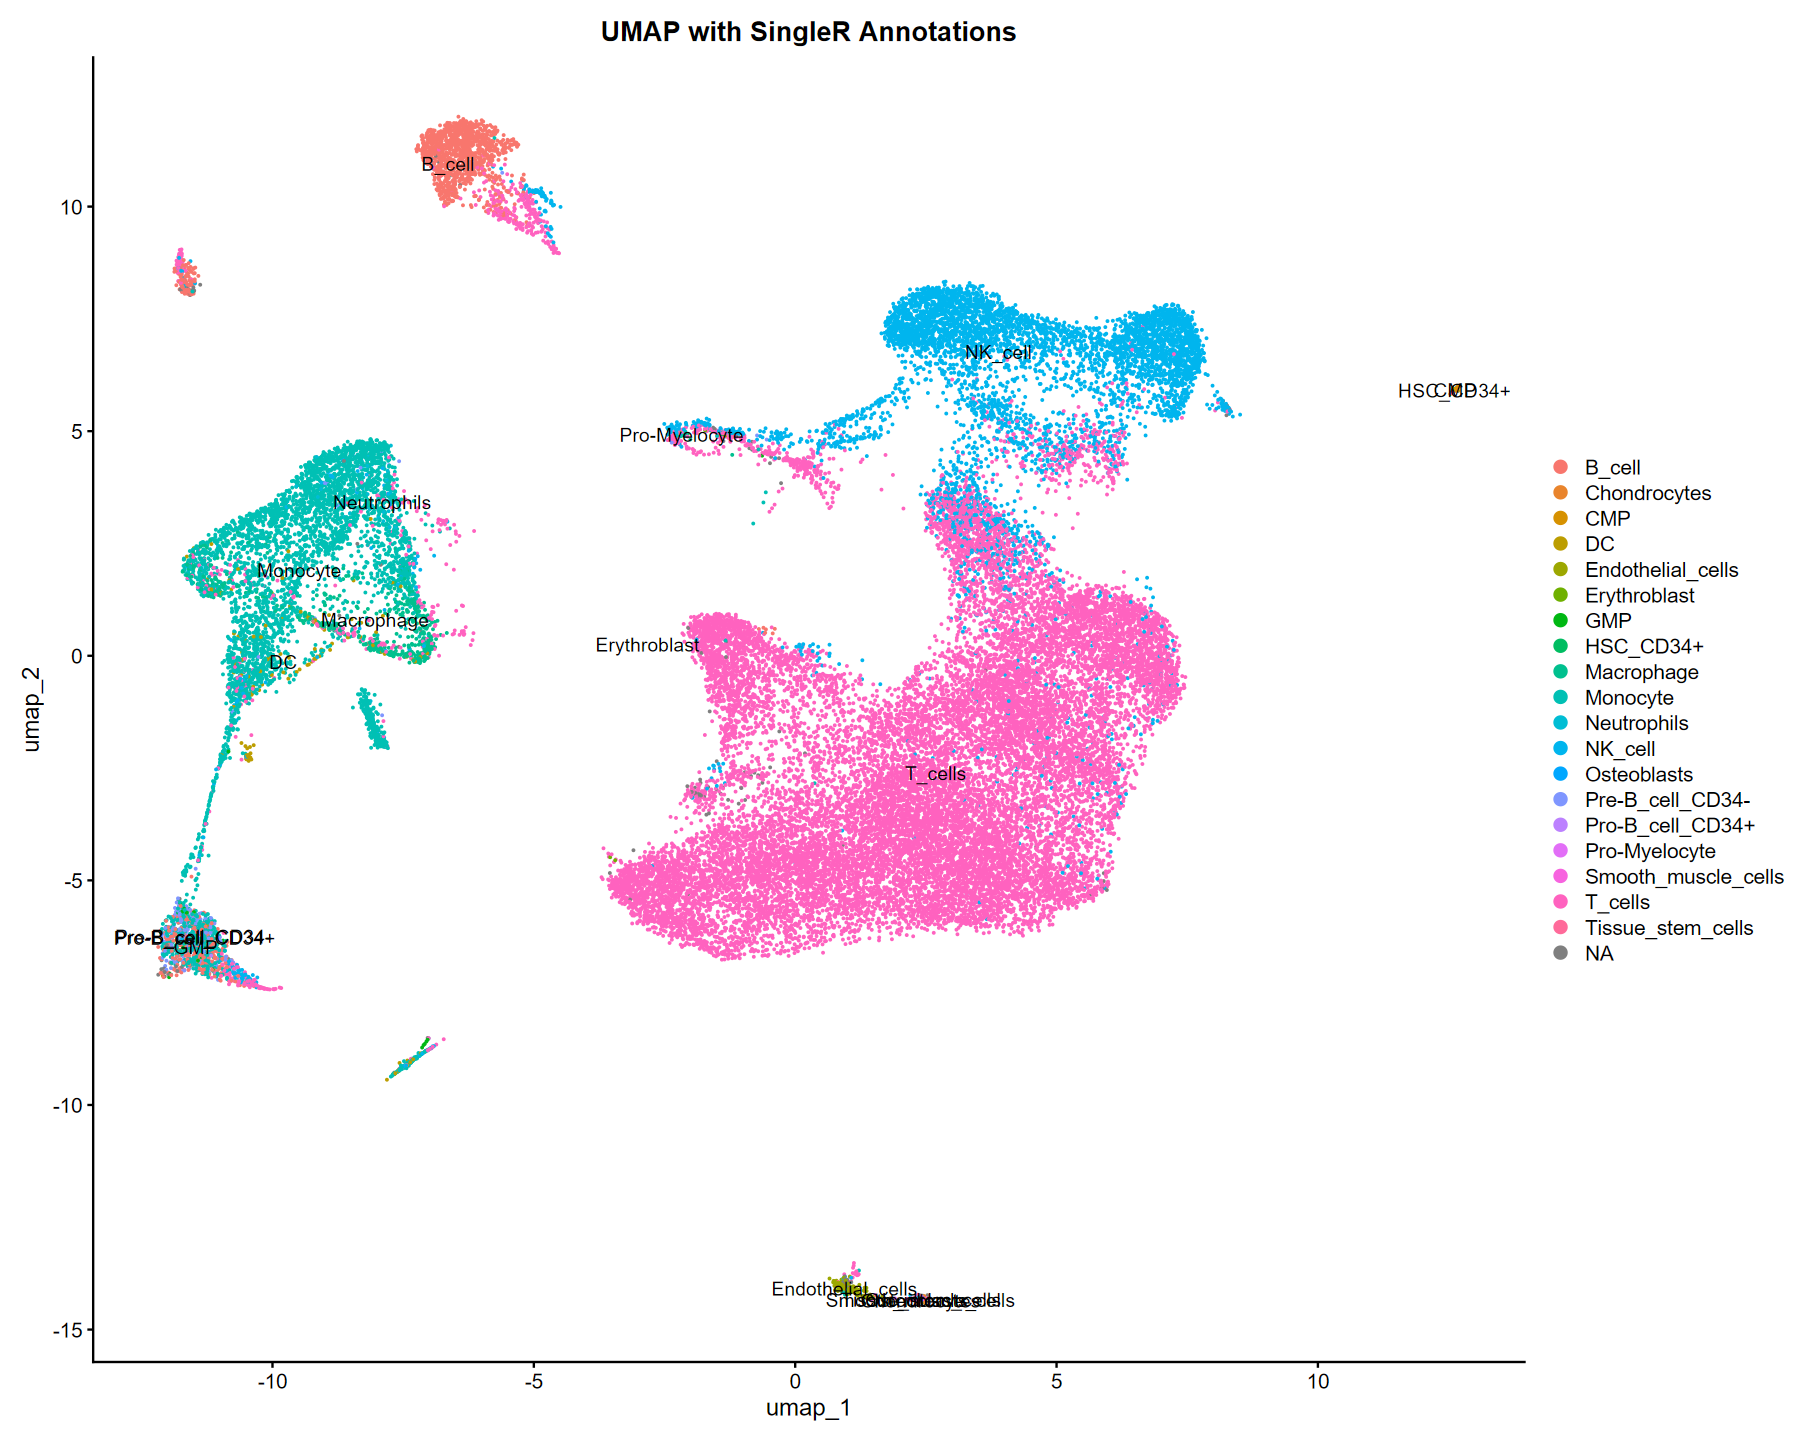

In [9]:
# Annotation code block

# Get reference atlas
hpca.se <- celldex::HumanPrimaryCellAtlasData()
data.sce <- as.SingleCellExperiment(data)

# Predict
pred.hpca <- SingleR(test = data.sce, ref = hpca.se, assay.type.test=1,
    labels = hpca.se$label.main)

# View annotations
cluster_table <- cbind(table(pred.hpca$pruned.labels, data.sce$seurat_clusters))
cluster_table

# Add SingleR predicted labels to Seurat metadata
data$SingleR_Labels <- pred.hpca$pruned.labels

# UMAP plot with SingleR labels
DimPlot(data, reduction = "umap", group.by = "SingleR_Labels", label = TRUE) + 
    ggtitle("UMAP with SingleR Annotations")

In [34]:
# Function to get the a specific cell type
get_macrophages <- function(data, table, cell_type = "Macrophages") {

    # Find clusters where atleast > 15% is classified as macrophages
    clusters <- which(t(cluster_table[cell_type, ] / colSums(cluster_table) * 100) > 5) - 1
    
    # Get subsets by first filtering on macrophage dominant clusters
    data <- subset(data, subset = seurat_clusters %in% clusters)

    # And then only select the macrophages
    data <- subset(data, subset = SingleR_Labels == cell_type)

    return(data)
}

macrophages <- get_macrophages(data, cluster_table, cell_type = "Macrophage")

Warning message:
"Removing 5 cells missing data for vars requested"


In [ ]:
# View distribution of cells
table(macrophages$orig.ident)


 P1  P2  P3  P4  P5  P6  P7  P8 
  2   4   9  20 225 142 103  51 

In [12]:
# Change orig.ident, since P1, P2, P3 and P4 have too few cells for it to be integrated with the other clusters downstream
test <- SplitObject(macrophages, split.by = "orig.ident")
test$P1$orig.ident <- "P1, P2, P3, P4 and P8"
test$P2$orig.ident <- "P1, P2, P3, P4 and P8"
test$P3$orig.ident <- "P1, P2, P3, P4 and P8"
test$P4$orig.ident <- "P1, P2, P3, P4 and P8"
test$P8$orig.ident <- "P1, P2, P3, P4 and P8"

In [13]:
# Merge the Seurat objects
macrophage_data <- merge(test$P1, y=list(test$P2, test$P3, test$P4, test$P5, test$P6, test$P7, test$P8),
                    add.cell.ids = c("P1, P2, P3, P4 and P8", "P1, P2, P3, P4 and P8", "P1, P2, P3, P4 and P8", "P1, P2, P3, P4 and P8", "P5", "P6", "P7", "P1, P2, P3, P4 and P8"),
                    project="All plaques merged")

# Merge layers
macrophage_data[["RNA"]] <- JoinLayers(macrophage_data[["RNA"]])

In [ ]:
# View distribution
table(macrophage_data$orig.ident, macrophage_data$seurat_clusters)

                       
                         14  15
  P1, P2, P3, P4 and P8  53  33
  P5                    126  99
  P6                     85  57
  P7                     62  41

In [15]:
# To reintegrate, there needs to be a new Seurat Object created
macrophage_data <- CreateSeuratObject(
    counts = macrophage_data@assays$RNA$counts)

In [16]:
# Reprocess the subset
macrophage_data <- pre_process(macrophage_data, resolutions = seq(0.1, 1, by=0.1), k.weight = 64)

Normalizing layer: counts.P1,_P2,_P3,_P4_and_P8

Normalizing layer: counts.P5

Normalizing layer: counts.P6

Normalizing layer: counts.P7

Finding variable features for layer counts.P1,_P2,_P3,_P4_and_P8

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -1.8287"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"neighborhood radius 0.49959"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"reciprocal condition number  1.5134e-14"
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"There are other near singularities as well. 0.090619"
Finding variable features for layer counts.P5

Finding variable features for layer counts.P6

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
"pseudoinverse used at -2.021"
Warning message in simpleLoess(y, x, w, span, degree = degree

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 409
Number of edges: 16367

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9000
Number of communities: 1
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 409
Number of edges: 16367

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8047
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 409
Number of edges: 16367

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7524
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 409
Number of edges: 16367

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7055
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version

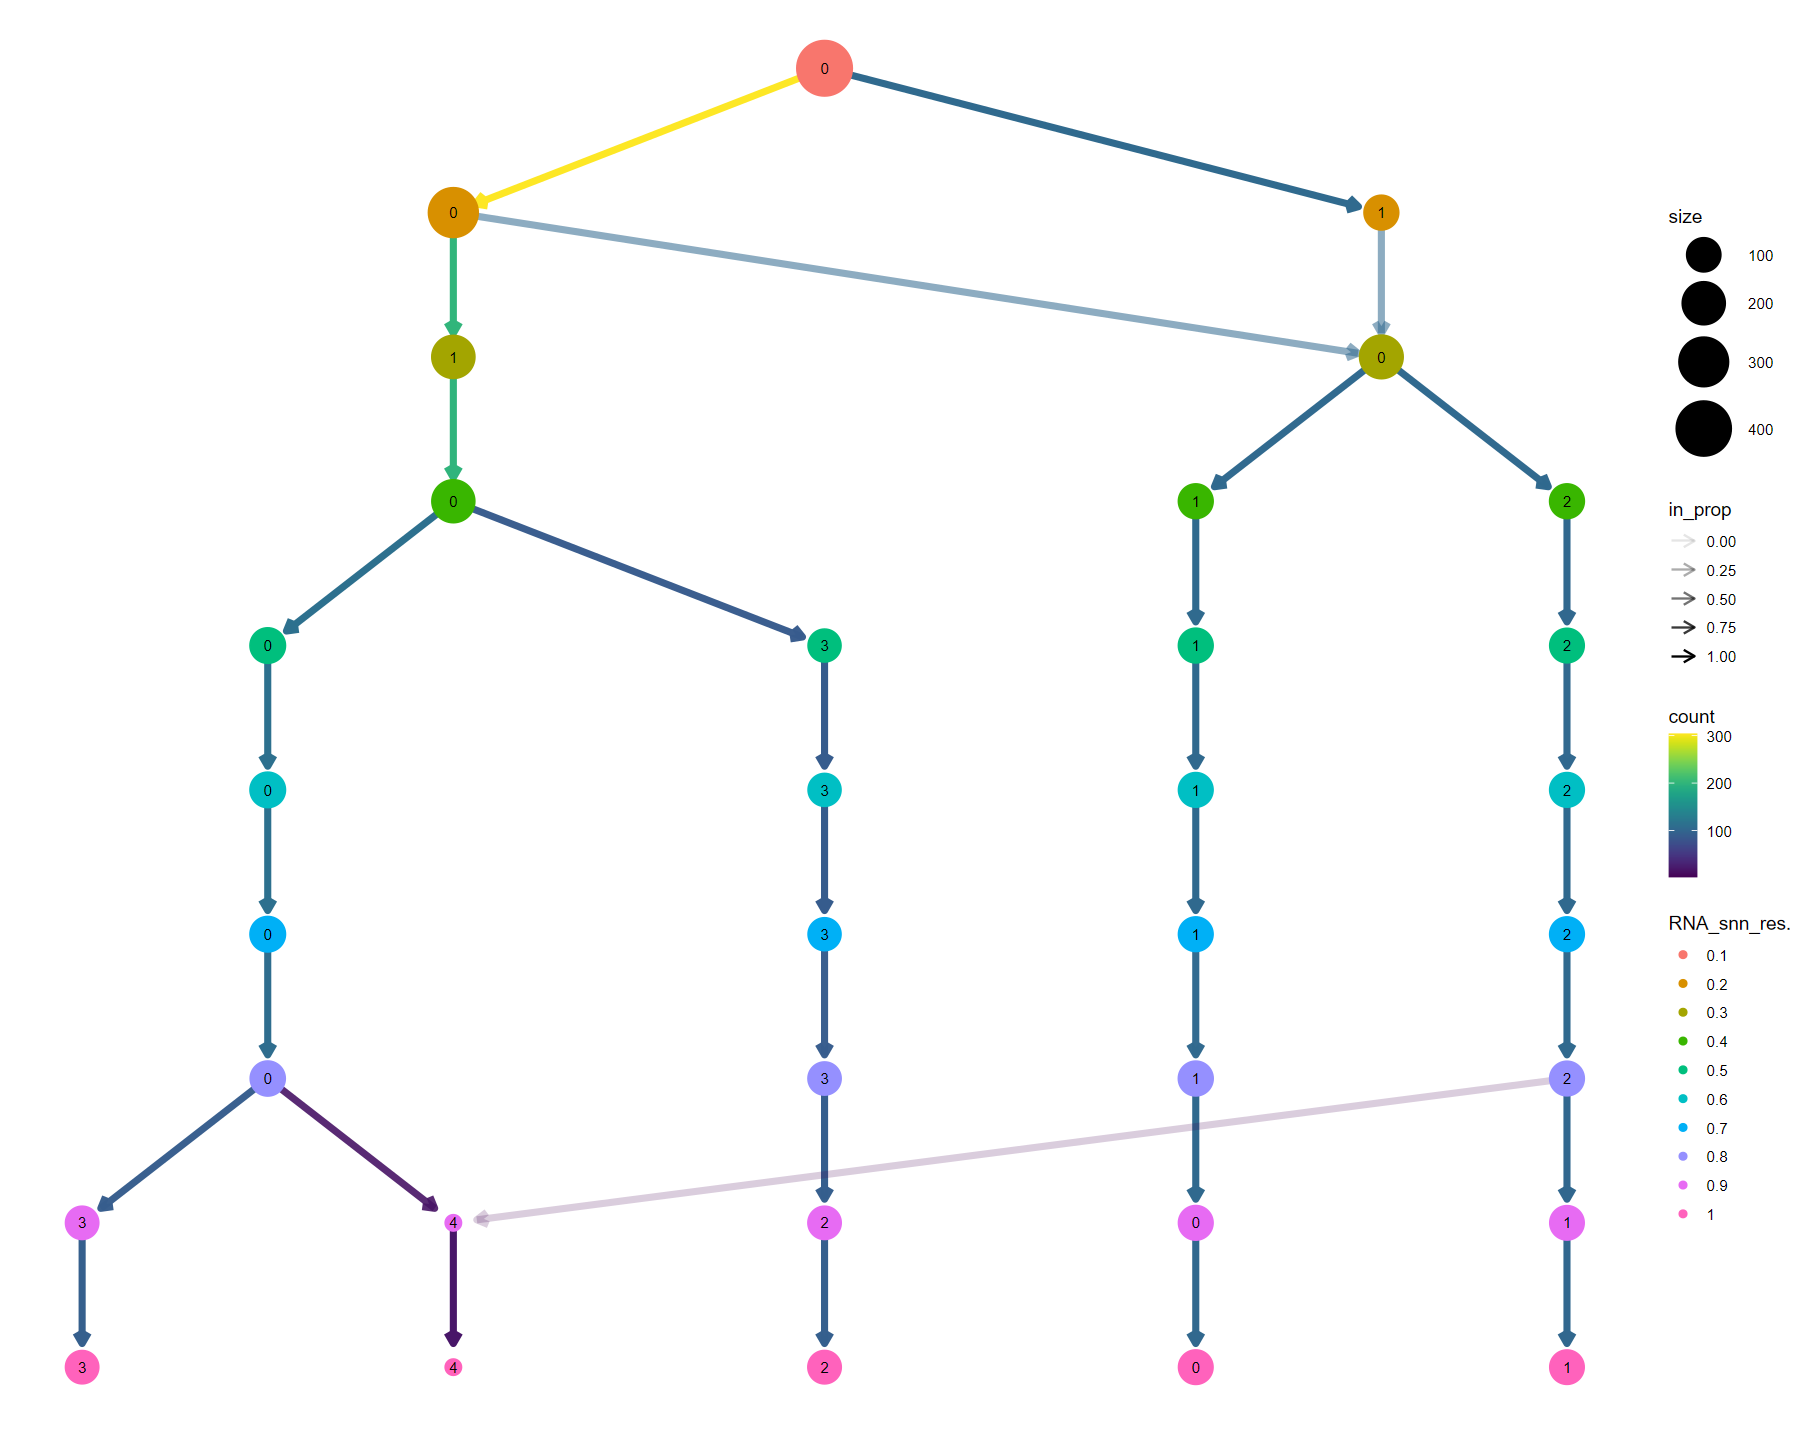

In [17]:
# View the clustree again for the best resolution
clustree(macrophage_data, prefix= "RNA_snn_res.", layout = "sugiyama")

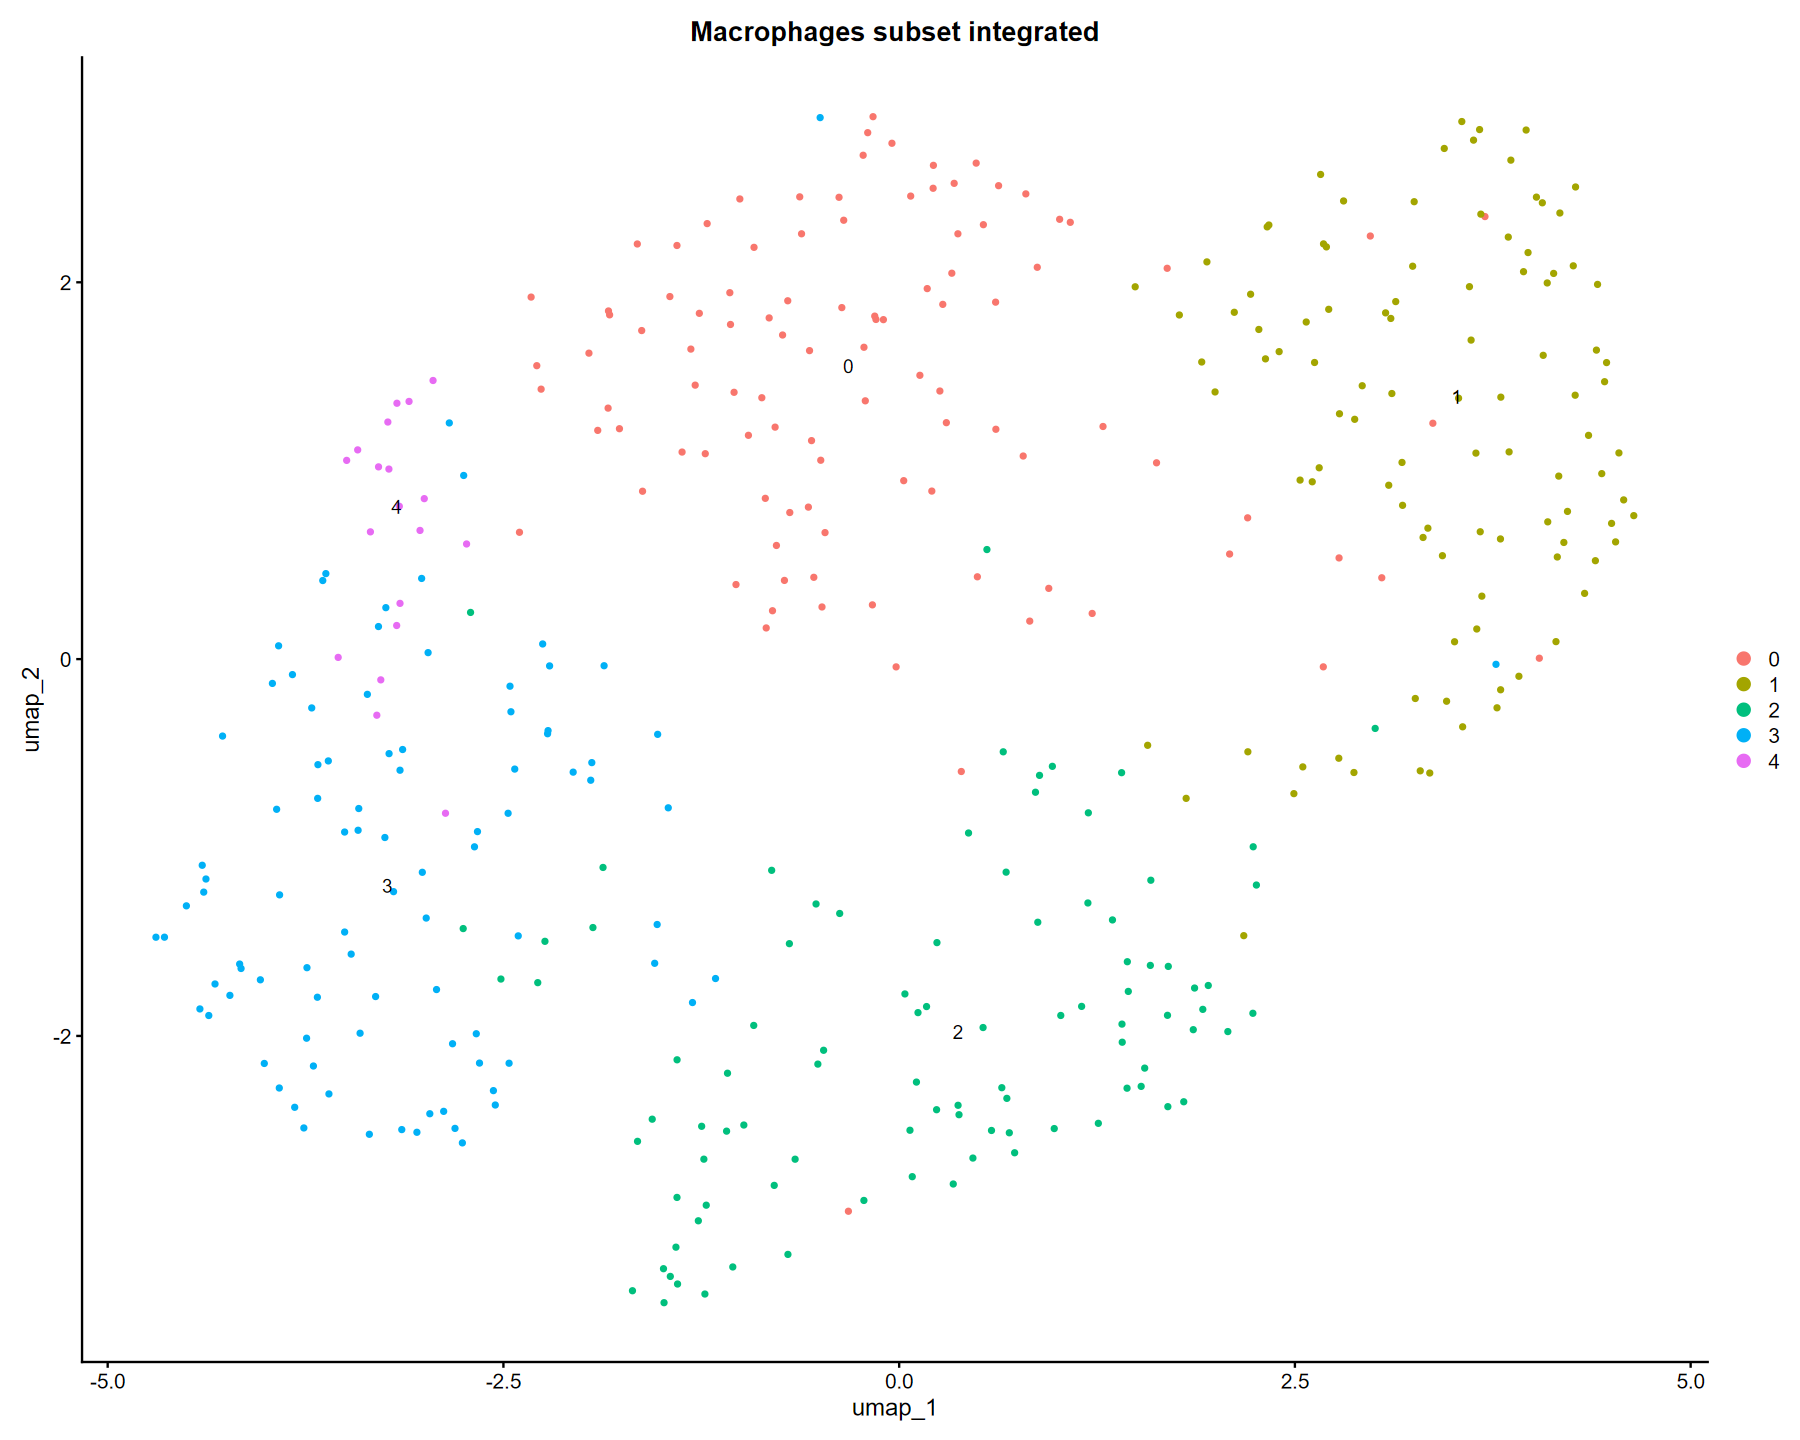

In [18]:
# Assign the slot "Seurat Cluster" to the desired resolution
macrophage_data$seurat_clusters <- macrophage_data$`RNA_snn_res.1`
Idents(macrophage_data) <- "seurat_clusters"

# Plot
DimPlot(macrophage_data, reduction = "umap", group.by = "RNA_snn_res.1", label = TRUE) + 
    ggtitle("Macrophages subset integrated")

In [19]:
# Some marker genes according to Winther & Willemsen
features_inflammatory <- c("S100A8", "S100A9", "IL1B", "CASP1", "CASP4", "NLRP3", "TNF", "EGR1", "ZPF36", "IER3", "CEPBP", "CXCL2", "CCL2-5")
features_resident <- c("LYVE1", "CX3CR1", "FOLR2", "C1QA", "C1QB", "C1QC", "CD74", "HLA-DRA", "HLA-DRB1", "PF4", "SEPP1", "VSIG4", "F13A1")
features_trem2 <- c("TREM2", "CD9", "FABP5", "APOE", "APOC1", "SPP1", "LGALS3", "CTSB")
features_trem1 <- c("TREM1", "TNF", "CEBPB", "Il1B", "CCL2", "CCL17", "CCL20", "CXCL1", "CXCL2", "CXCL3", "CXCL8" )
features_ifnic <- c("ISG15", "IRF7", "IFIT3", "IFIT1")
features_proliferating <- c("STMN1", "TOP2A", "MKI67", "TUBA1B", "TUBB5")
features_monocytes <- c("CD14", "CD16", "HLA-DR", "CCR2", "CX3CR1", "CD11b", "CD64", "LYZ")



# Add a module score to the Seurat object
macrophage_data <- AddModuleScore(macrophage_data, features = list(features_inflammatory), name = "FeatureGeneScore_inflammatory")
macrophage_data <- AddModuleScore(macrophage_data, features = list(features_resident), name = "FeatureGeneScore_resident_like")
macrophage_data <- AddModuleScore(macrophage_data, features = list(features_trem2), name = "FeatureGeneScore_trem2")

# Vln plots
inflammatory_vln <- VlnPlot(macrophage_data, features = "FeatureGeneScore_inflammatory1", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for inflammatory macrophage markers")
residents_vln <- VlnPlot(macrophage_data, features = "FeatureGeneScore_resident_like1", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for resident-like macrophage markers")
trem2_vln <- VlnPlot(macrophage_data, features = "FeatureGeneScore_trem21", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for trem2 foamy macrophage markers")

# Visualizing DotPlots to view marker genes
inflammatory_dot <- DotPlot(macrophage_data, features = features_inflammatory) + 
  ggtitle("Inflammatory Macrophages") + RotatedAxis()

resident_dot <- DotPlot(macrophage_data, features = features_resident) + 
  ggtitle("Resident-Like Macrophages")

TREM2_dot <- DotPlot(macrophage_data, features = features_trem2) + 
  ggtitle("TREM2 'Foamy' Macrophages")

IFNIC_dot <- DotPlot(macrophage_data, features = features_ifnic) + 
  ggtitle("IFNIC Macrophages")

proliferating_dot <- DotPlot(macrophage_data, features = features_proliferating) + 
  ggtitle("Proliferating Macrophages")


Warning message:
"The following features are not present in the object: ZPF36, CEPBP, CCL2-5, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: SEPP1, not searching for symbol synonyms"
Warning message:
"The following requested variables were not found: ZPF36, CEPBP, CCL2-5"
Warning message:
"The following requested variables were not found: SEPP1"
Warning message:
"The following requested variables were not found: TUBB5"


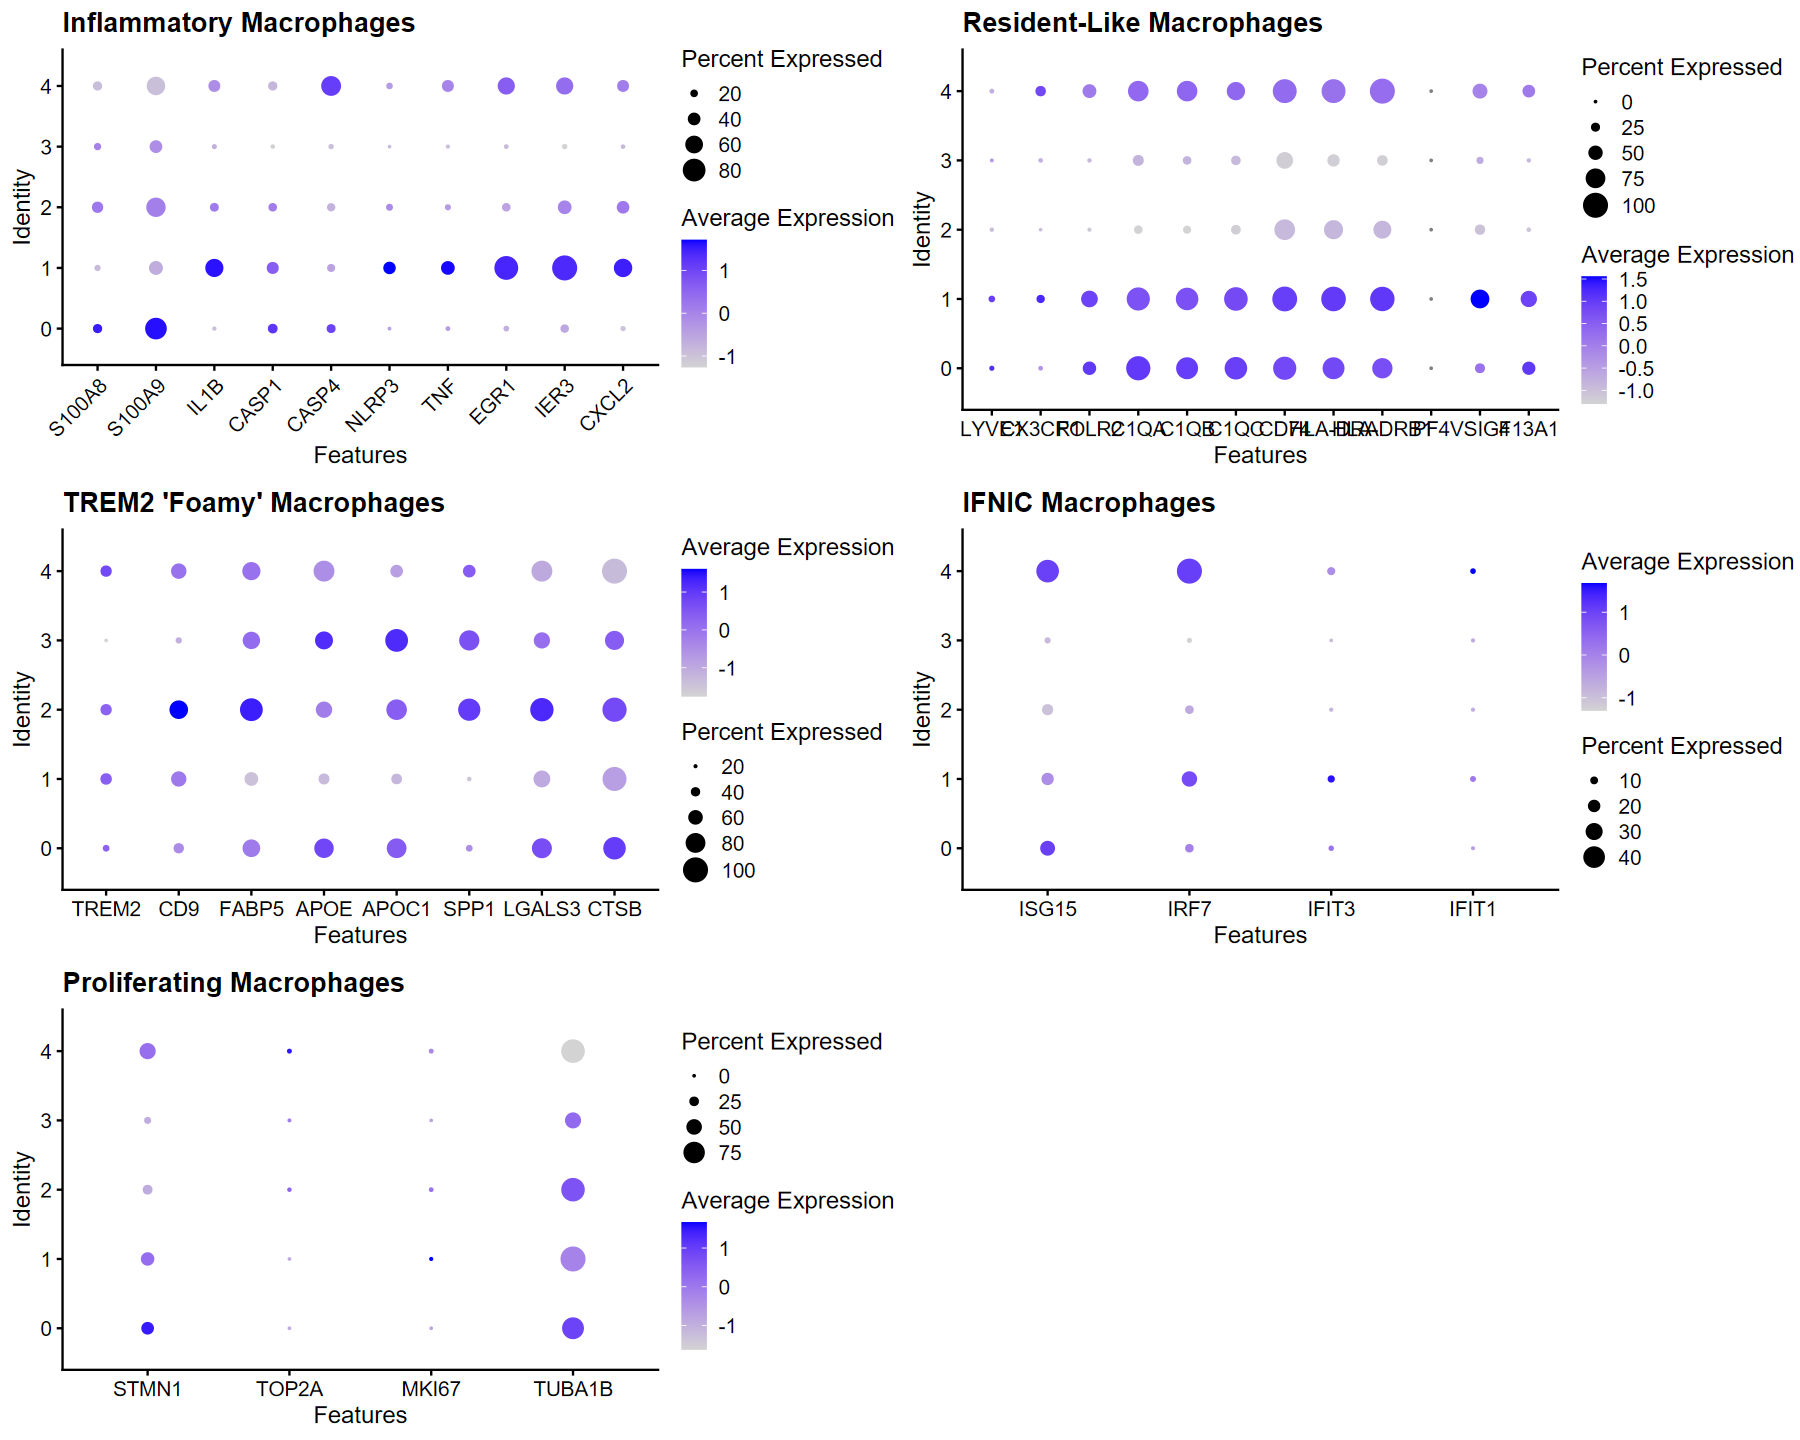

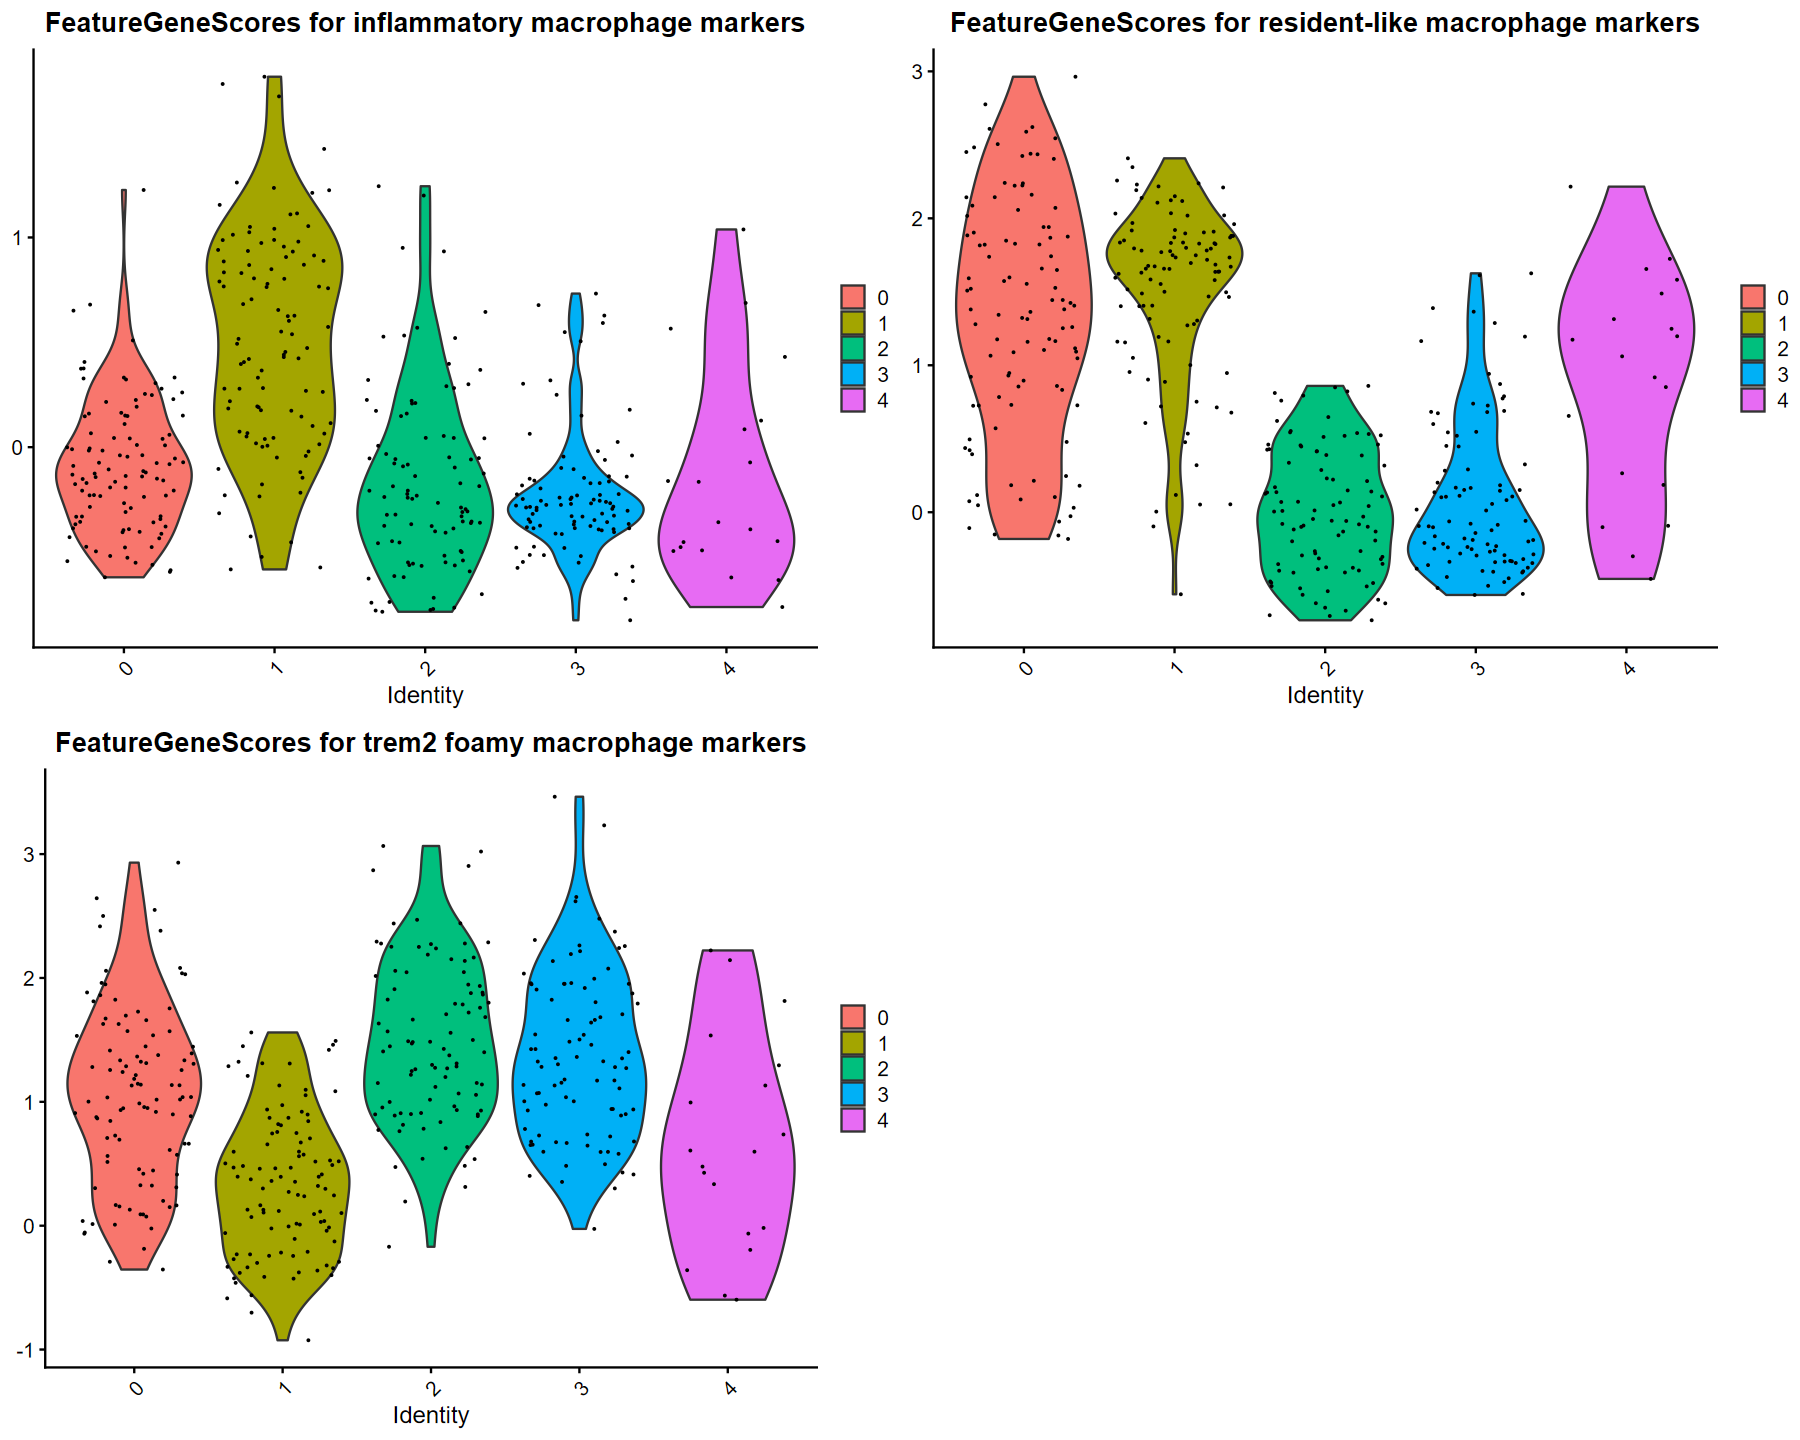

In [20]:
# Plot
grid.arrange(inflammatory_dot, resident_dot, TREM2_dot, IFNIC_dot, proliferating_dot, ncol = 2)
grid.arrange(inflammatory_vln, residents_vln, trem2_vln, ncol=2)


In [32]:
# Assign new labels
macrophage_data <- SetIdent(macrophage_data, value = "seurat_clusters")
macrophage_data <- RenameIdents(macrophage_data,
                                   '0' = 'Resident-like Macrophages', #'TREM2 Foamy Macrophages',
                                   '1' = 'Inflammatory Macrophages', #Resident-like Macrophages
                                   '2' = 'TREM2 Foamy Macrophages', 
                                   '3' = 'TREM2 Foamy Macrophages',
                                   '4' = 'Resident-like Macrophages')

# Proportion tables
annotations_per_origin <- table(Idents(macrophage_data), macrophage_data$orig.ident)
annotations_per_origin_prop <- prop.table(table(Idents(macrophage_data), macrophage_data$orig.ident), margin = 2) * 100

# Subtype plots after annotation
subtype_annotated_plot <- DimPlot(macrophage_data, reduction = "umap", label = TRUE)
subtype_origin_plot <- DimPlot(macrophage_data, reduction = "umap", group.by = "orig.ident", label = TRUE)
annotations_total <- prop.table(table(Idents(macrophage_data))) * 100


# Combine tables side by side
combined_df <- cbind(annotations_per_origin, annotations_per_origin_prop, annotations_total)

,"P1, P2, P3, P4 and P8",P5,P6,P7,"P1, P2, P3, P4 and P8",P5,P6,P7,annotations_total
Resident-like Macrophages,32,36,23,31,50.0000,22.36025,23,36.90476,29.82885
Inflammatory Macrophages,9,50,26,17,14.0625,31.05590,26,20.23810,24.93888
TREM2 Foamy Macrophages,23,75,51,36,35.9375,46.58385,51,42.85714,45.23227


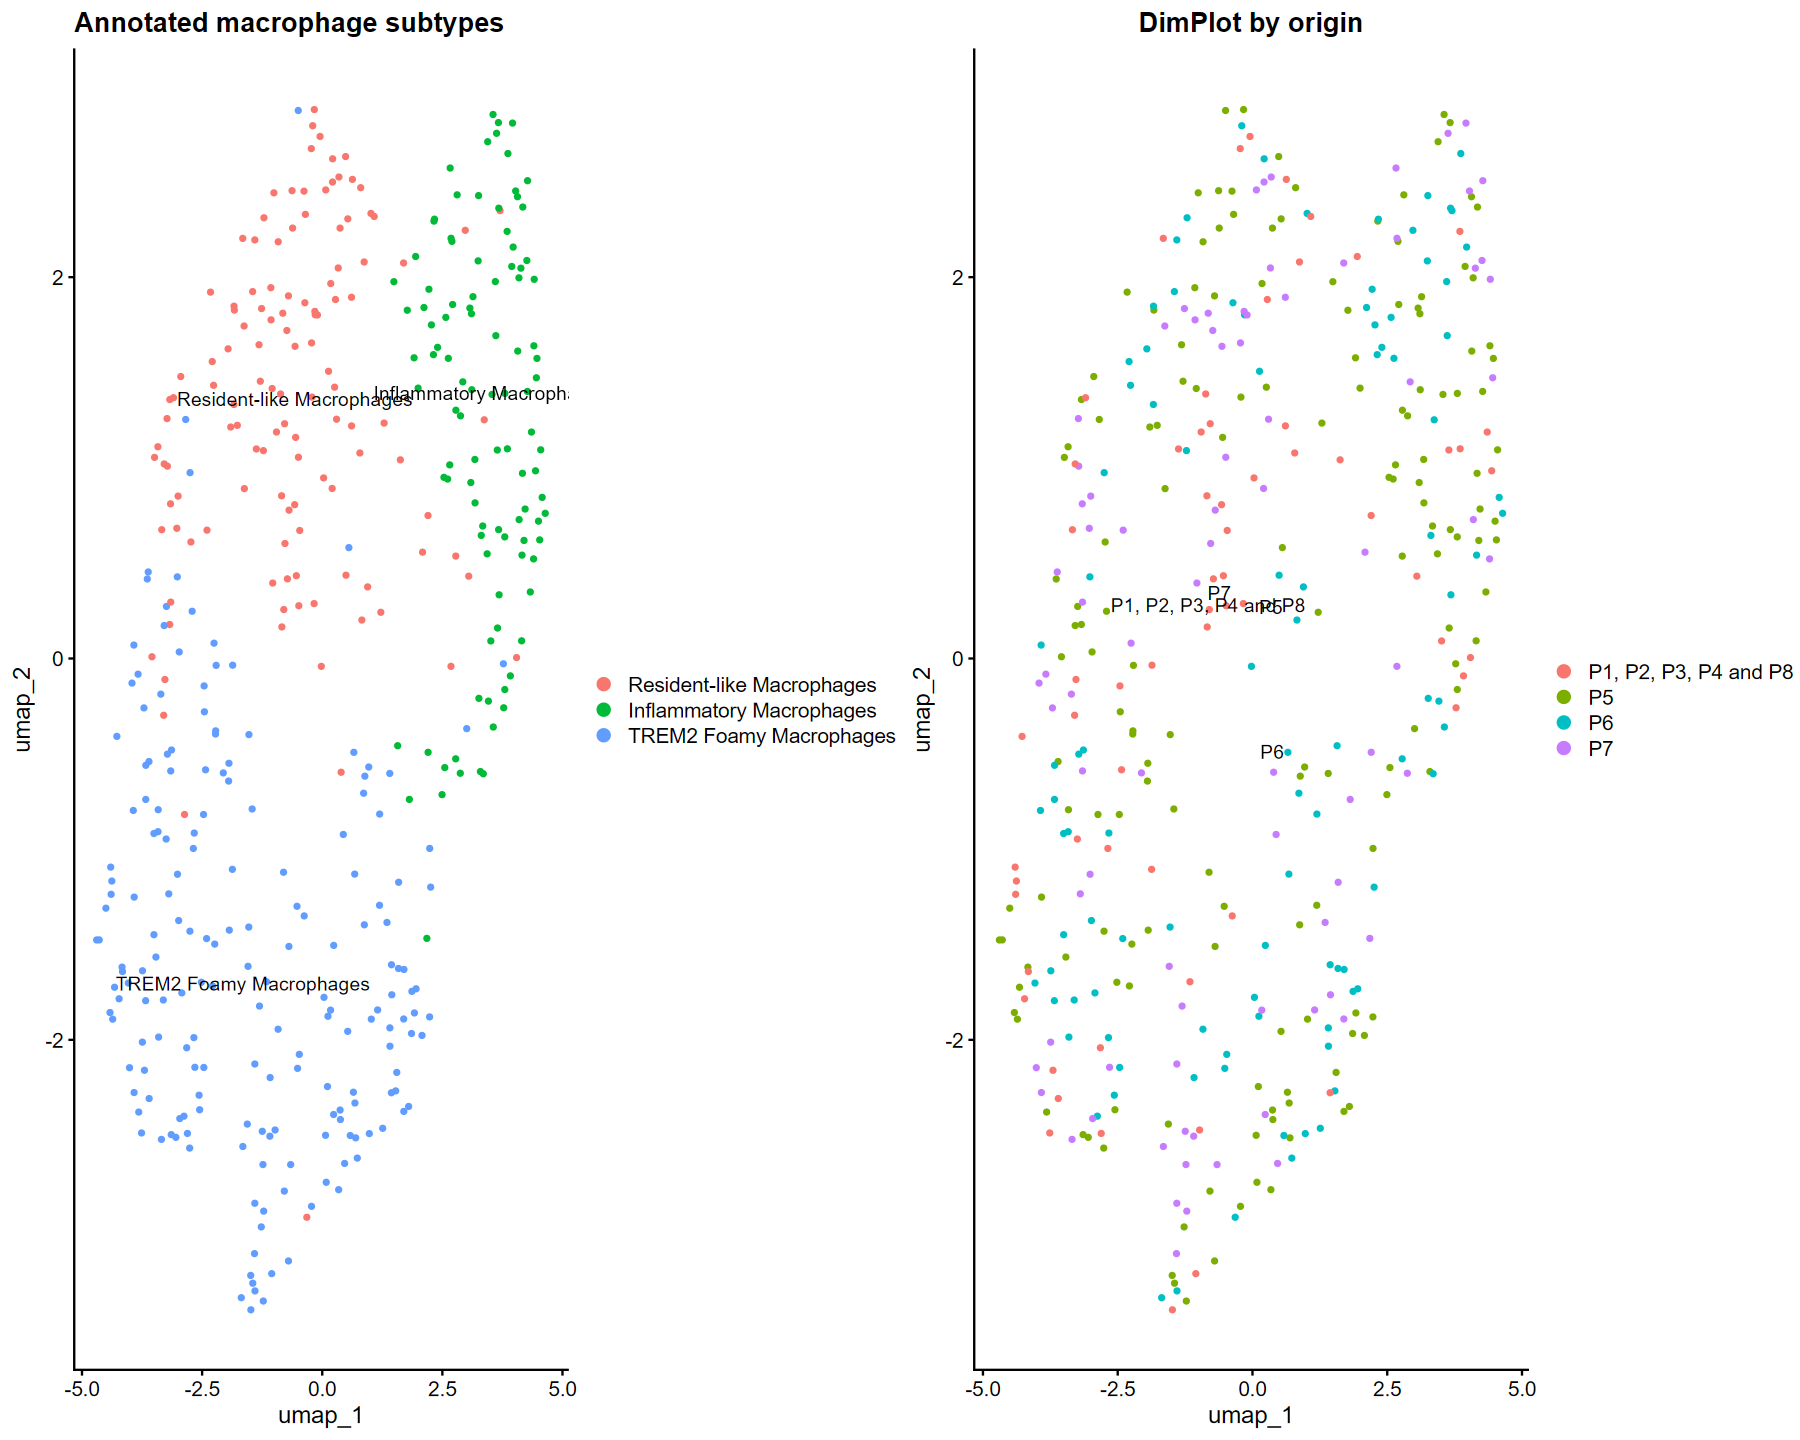

In [33]:
# Plot table
combined_df

# Plotting annotations and titles
grid.arrange(
    subtype_annotated_plot + ggtitle("Annotated macrophage subtypes"),
    subtype_origin_plot + ggtitle("DimPlot by origin"),
    ncol=2
)

In [28]:
# Save final object
saveRDS(macrophage_data, file = "Horstmann_macrophages_annotated2.rds")